# Fine-tuning with BERT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First let's install the pytorch and transformers packages

In [2]:
!pip install torch torchvision transformers

     |████████████████████████████████| 2.9 MB 5.3 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 596 kB 49.5 MB/s 
     |████████████████████████████████| 895 kB 46.8 MB/s 
     |████████████████████████████████| 3.3 MB 41.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


The installation will take a couple minutes.

Once the packages are installed, we'll load a pre-trained BERT model. We'll use the smaller uncased BERT model (uncased means the data used for pre-training BERT is all lowercased).

In [3]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer
import pandas as pd

class TweetDataset(Dataset):

    def __init__(self, filename, maxlen):

        #Store the contents of the file in a pandas dataframe
        self.df = pd.read_csv(filename, delimiter = '\t')

        #Initialize the BERT tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        #Selecting the sentence and label at the specified index in the data frame
        sentence = self.df.loc[index, 'text']
        # minus 1 after train
        label = self.df.loc[index, 'label'] + 1

        #Preprocessing the text to be suitable for BERT
        tokens = self.tokenizer.tokenize(sentence) #Tokenize the sentence
        tokens = ['[CLS]'] + tokens + ['[SEP]'] #Insering the CLS and SEP token in the beginning and end of the sentence
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))] #Padding sentences
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]'] #Prunning the list to be of specified max length

        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) #Obtaining the indices of the tokens in the BERT Vocabulary
        tokens_ids_tensor = torch.tensor(tokens_ids) #Converting the list to a pytorch tensor

        #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attn_mask = (tokens_ids_tensor != 0).long()

        return tokens_ids_tensor, attn_mask, label

Now let's create the training and development data using the `TweetDataset` class and pytorch's `DataLoader`.

In [4]:
from torch.utils.data import DataLoader

#Creating instances of training and development set
#maxlen sets the maximum length a sentence can have
#any sentence longer than this length is truncated to the maxlen size

train_set = TweetDataset(filename = '/content/drive/MyDrive/nlp/train_dev_data/train.tsv', maxlen = 128)
dev_set = TweetDataset(filename = '/content/drive/MyDrive/nlp/train_dev_data/dev.tsv', maxlen = 128)
# test_set = TweetDataset(filename = '/content/drive/MyDrive/nlp/url_user_test.tsv', maxlen = 128)
# test_set = TweetDataset(filename = '/content/drive/MyDrive/nlp/covid.csv', maxlen = 128)
#Creating intsances of training and development dataloaders

train_loader = DataLoader(train_set, batch_size = 32, num_workers = 2)
dev_loader = DataLoader(dev_set, batch_size = 32, num_workers = 2)
# test_loader = DataLoader(test_set, batch_size = 32, num_workers = 2)
# test_loader = DataLoader(test_set, batch_size = 32, num_workers = 2)
# print("Done preprocessing training and development data.")
# print(test_set.__getitem__(1))
# print(test_loader)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
import torch
import torch.nn as nn
from transformers import BertModel

class Classifier(nn.Module):

    def __init__(self):
        super(Classifier, self).__init__()
        #Instantiating BERT model object 
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        
        #Classification layer
        #input dimension is 768 because [CLS] embedding has a dimension of 768
        #output dimension is 1 because we're working with a binary classification problem
        self.cls_layer = nn.Linear(768, 17)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        outputs = self.bert_layer(seq, attention_mask = attn_masks)
        cont_reps = outputs.last_hidden_state

        #Obtaining the representation of [CLS] head (the first token)
        cls_rep = cont_reps[:, 0]

        #Feeding cls_rep to the classifier layer
        logits = self.cls_layer(cls_rep)

        return logits

Now let's create the sentiment classifier with pre-trained BERT's parameters. We'll put the model on GPU. This step might take a bit of time.

In [6]:
gpu = 0 #gpu ID

print("Creating the classifier, initialised with pretrained BERT-BASE parameters...")
net = Classifier()
net.cuda(gpu) #Enable gpu support for the model
print("Done creating the classifier.")

Creating the sentiment classifier, initialised with pretrained BERT-BASE parameters...


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Done creating the sentiment classifier.


We need to define a loss function for our model. Since it's a classification task, we'll use cross-entropy. We'll also use Adam as our optimiser.

In [7]:
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics

# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
# criterion = nn.functional.cross_entropy()
opti = optim.Adam(net.parameters(), lr = 2e-5)

Next let's define the training function. During training, we fetch a minibatch of examples from the data loader, and feed it to the classifier to get the output logits and compute the loss. `loss.backward()` is a function to compute the gradients for the parameters based on the loss, and `opti.step()` is a function to update parameters using the gradients.

In [8]:
import time

def train(net, criterion, opti, train_loader, dev_loader, max_eps, gpu):

    best_acc = 0
    st = time.time()
    for ep in range(max_eps):
        
        for it, (seq, attn_masks, labels) in enumerate(train_loader):
            #Clear gradients
            opti.zero_grad()  
            #Converting these to cuda tensors
            seq, attn_masks, labels = seq.cuda(gpu), attn_masks.cuda(gpu), labels.cuda(gpu)

            #Obtaining the logits from the model
            logits = net(seq, attn_masks)

            #Computing loss
            # loss = criterion(logits.squeeze(-1), labels.float())
            # print('--------------',logits)
            loss = nn.functional.cross_entropy(logits.squeeze(-1), labels)

            #Backpropagating the gradients
            loss.backward()

            #Optimization step
            opti.step()
            print('train: ',it)
            if it % 100 == 0:
                
                # acc = get_accuracy_from_logits(logits, labels)
                # print('----------------',logits)
                true = labels.data.cpu()
                predic = torch.max(logits.data, 1)[1].cpu()
                acc = metrics.accuracy_score(true, predic)
                print("Iteration {} of epoch {} complete. Loss: {}; Accuracy: {}; Time taken (s): {}".format(it, ep, loss.item(), acc, (time.time()-st)))
                st = time.time()

        
        dev_acc, dev_loss = evaluate(net, criterion, dev_loader, gpu)
        print("Epoch {} complete! Development Accuracy: {}; Development Loss: {}".format(ep, dev_acc, dev_loss))
        if dev_acc > best_acc:
            print("Best development accuracy improved from {} to {}, saving model...".format(best_acc, dev_acc))
            best_acc = dev_acc
            torch.save(net.state_dict(), 'tweeturl_user_{}.dat'.format(ep))

Notice that we check the development performance after every training epoch, and only save the model when we see a performance improvement.

A couple more housekeeping functions we need to define for evaluation.

In [9]:
# def get_accuracy_from_logits(logits, labels):
#     probs = torch.sigmoid(logits.unsqueeze(-1))
#     soft_probs = (probs > 0.5).long()
#     acc = (soft_probs.squeeze() == labels).float().mean()
#     return acc

def evaluate(net, criterion, dataloader, gpu):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        for seq, attn_masks, labels in dataloader:
            seq, attn_masks, labels = seq.cuda(gpu), attn_masks.cuda(gpu), labels.cuda(gpu)
            logits = net(seq, attn_masks)
            # mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            mean_loss += nn.functional.cross_entropy(logits, labels)

            labels = labels.data.cpu().numpy()
            predict = torch.max(logits.data, 1)[1].cpu().numpy()
            # labels_all = np.append(labels_all, labels)
            # predict_all = np.append(predict_all, predic)
                                    
            # print('------outputs',logits)
            # print('-------labels',labels)
            mean_acc += metrics.accuracy_score(labels, predict)
            print('dev ',count)
            count += 1

            

    return mean_acc / count, mean_loss / count

We're almost ready to fine-tune the sentiment classifier! We'll train with 1 epoch and see what performance we get.

There are about 1000 iterations for one epoch, and generally 100 iterations takes about 20-35 seconds (depending what GPU you're randomly allocated), so one epoch of training should hopefully take no more than 10 minutes.

In [10]:
num_epoch = 10

#fine-tune the model
train(net, criterion, opti, train_loader, dev_loader, num_epoch, gpu)

train:  0
Iteration 0 of epoch 0 complete. Loss: 2.753122329711914; Accuracy: 0.21875; Time taken (s): 1.665221929550171
train:  1
train:  2
train:  3
train:  4
train:  5
train:  6
train:  7
train:  8
train:  9
train:  10
train:  11
train:  12
train:  13
train:  14
train:  15
train:  16
train:  17
train:  18
train:  19
train:  20
train:  21
train:  22
train:  23
train:  24
train:  25
train:  26
train:  27
train:  28
train:  29
train:  30
train:  31
train:  32
train:  33
train:  34
train:  35
train:  36
train:  37
train:  38
train:  39
train:  40
train:  41
train:  42
train:  43
train:  44
train:  45
train:  46
train:  47
train:  48
train:  49
train:  50
train:  51
train:  52
train:  53
train:  54
train:  55
train:  56
train:  57
train:  58
train:  59
train:  60
train:  61
train:  62
train:  63
train:  64
train:  65
train:  66
dev  0
dev  1
dev  2
dev  3
dev  4
dev  5
dev  6
dev  7
dev  8
dev  9
dev  10
dev  11
dev  12
dev  13
dev  14
dev  15
dev  16
dev  17
dev  18
dev  19
dev  20
dev 

In [11]:
#load model to predict
# Load
net = Classifier()
# model.load_state_dict(torch.load(PATH))
# net.load_state_dict(torch.load('/content/drive/MyDrive/nlp/bert/tweeturlcls_0.dat'))
# net.load_state_dict(torch.load('/content/drive/MyDrive/nlp/bert/tweeturl_user_cls_0_88.dat'))
net.load_state_dict(torch.load('/content/tweeturl_user_8.dat'))
gpu = 0 #gpu ID
net.cuda(gpu) #Enable gpu support for the model
print("Done creating the sentiment classifier.")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Done creating the sentiment classifier.


In [12]:
import time

def predict(net, criterion, dataloader, gpu):
    net.eval()
    count = 0
    y_pred = []

    with torch.no_grad():
        for seq, attn_masks, labels in dataloader:
            seq, attn_masks = seq.cuda(gpu), attn_masks.cuda(gpu)
            logits = net(seq, attn_masks)
            
            predict = torch.max(logits.data, 1)[1].cpu().numpy()
            print('predict',predict)
            y_pred.extend(predict)
            
            # mean_acc += metrics.accuracy_score(labels, predict)
            print('dev ',count)
            count += 1
        
    return y_pred

In [13]:
y_pred = predict(net, criterion, dev_loader, gpu)

predict [ 6  3  2  4  1  5  2  2  0  6  4  4 15  2  5 15  4  2  5  2  8  2  3  8
  6  5  9  2  2  4  2  1]
dev  0
predict [ 2  9  6 15  2  9  4 15  5  2  2  1  2  2 10  2  4  4  4  2  0  7  6  2
  4  5  6  6  9  8  8  4]
dev  1
predict [ 7 15  4  4 13  2  2  1 15  2  6  6  6  5  6  2  1  3  9  2  3  6 10  6
 12  6  1  4  1  4  4  2]
dev  2
predict [ 2  8  6 14  2  9  1  4  2  5  2  4  8  2  5  4  2 12  6 10  9 12  3  4
  1  4  6  4  8  5  2  1]
dev  3
predict [10  4  1  5  4  2  6  2  2  6  8  4  2  4  8  2  4  2  4  7  2  5 13  2
  4  6  2  2  7  5  6  2]
dev  4
predict [ 9  2  2  1 15  6  2  2  4  6  6  5  2  2  2  4  4  2  6  5  1  6  2  1
 11  1  4  6  4  2  9  8]
dev  5
predict [ 4  2  6  4  1  8  9  9  4  2  4  5  9  4  9  4  4  4  2 10  2  5 15 11
  2  3  2  2  8  2  6  6]
dev  6
predict [ 2  5  3  5  2  1 13  2 14  4  6  2  6  4  4  9  0  3  2  9  1  4  1  8
  2  2  8  6  2 12  9  1]
dev  7
predict [ 1  1  2  5  6  2  4  5  9  4  7  2  8  3  6  2  2  1  2  1  2  2  4 11
  5  4 

In [14]:
#print the classification_report
from sklearn import metrics
import numpy as np
dev_df = pd.read_csv('/content/drive/MyDrive/nlp/train_dev_data/dev.tsv', delimiter = '\t')
print(len(dev_df['label'].iloc[:].values))
print(len(y_pred))
y_pred = [ i-1 for i in y_pred]
print(metrics.classification_report(dev_df['label'].iloc[:].values,y_pred))


915
915
              precision    recall  f1-score   support

          -1       0.38      0.15      0.21        20
           0       0.50      0.52      0.51        69
           1       0.75      0.82      0.78       214
           2       0.66      0.55      0.60        38
           3       0.82      0.86      0.84       187
           4       0.69      0.75      0.72        79
           5       0.64      0.66      0.65        95
           6       0.54      0.54      0.54        13
           7       0.80      0.78      0.79        51
           8       0.75      0.73      0.74        60
           9       0.57      0.36      0.44        22
          10       0.43      0.43      0.43         7
          11       0.64      0.64      0.64        11
          12       0.58      0.50      0.54        22
          13       0.67      0.67      0.67         6
          14       1.00      0.75      0.86        20
          15       0.00      0.00      0.00         1

    accuracy      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


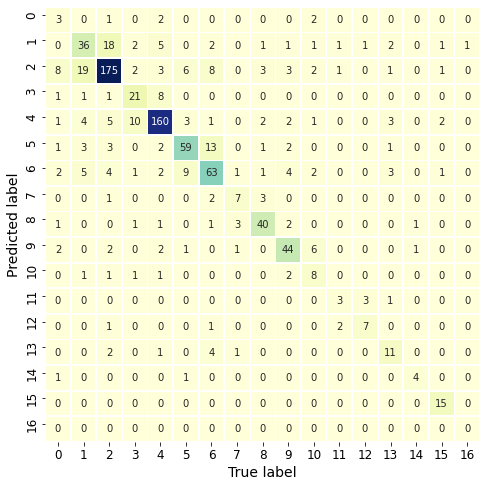

In [15]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# evaluate the performance of prediction , calculate the confusion_matrix
# confm = metrics.confusion_matrix(np.argmax(dev_pre,axis=1),np.argmax(dev_y,axis=1))
confusion = metrics.confusion_matrix(dev_df['label'].iloc[:].values,y_pred)
## Confusion matrix visualization
Labname=['-1'].append(str(i) for i in range(17))
plt.figure(figsize=(8,8))
sns.heatmap(confusion.T, square=True, annot=True,
            fmt='d', cbar=False,linewidths=.8,
            cmap="YlGnBu")
plt.xlabel('True label',size = 14)
plt.ylabel('Predicted label',size = 14)
plt.xticks(np.arange(17)+0.5,Labname,size = 12)
plt.yticks(np.arange(17)+0.3,Labname,size = 12)
plt.show()

# print(confusion)

In [ ]:
# test_df = pd.read_csv('/content/drive/MyDrive/nlp/test.tsv', delimiter = '\t')
new_test_df = pd.read_csv('/content/drive/MyDrive/nlp/url_user_test.tsv', delimiter = '\t')
# print(test_df[300:310])
# print(new_test_df[300:310]['text'])

In [ ]:
## write predictions to json
# from collection import OrderedDict
import json
def write2json(filename,data,predicted):
    """
    args: 
        filename: the filename of the predicted data label file
        data: [id1,id2,]the text data which used to be predicted
        predicted: [label1,label2]the predicted label of the data
    return:
        None
    """
    result = {}
    for i in range(len(data)):
        result[data[i]] = predicted[i]
    json_tweet = json.dumps(result)
    with open(filename, "w+", encoding="utf8") as json_file:
        json_file.write(json_tweet)
    return None

In [ ]:
write2json('test-output.json',new_test_df.iloc[:]['id'].values.tolist(),labels)

Hopefully your model should get around 90% accuracy, which is a pretty good performance. Feel free to run again but with more epochs and see if you can get a better performance.